In [430]:
#!/usr/bin/env python3
# import libraries
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import time
import warnings
warnings.filterwarnings("ignore")
from catboost import CatBoostClassifier, Pool
from imblearn.under_sampling import RandomUnderSampler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import binarize
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from xgboost import XGBClassifier

In [431]:
class Preprocessing:
    def __init__(self):
        '''initialize variables and column names for null dataframe'''
        self.df_train = df_train.copy()
        self.list_col = []
        self.list_total = []
        self.dict_unique = {}
        self.list_datatype = []
        self.list_unique_val = []
        self.list_mode_count = []
        self.list_mode_value = []
        self.list_mode_count_perc = []
        self.list_unique_total = []
        self.list_unique_first_10 = []
        self.column_names = ['col_name', 'total_null', 'datatype', 'total_unique',
                             'mode_value', 'mode_count', 'mode_percentage']

    def missing_values(self):
        '''check for null values and add to null dataframe if more than 0 nulls exist'''
        self._correct_nan_value() #testing commenting out 
        for val in self.df_train.columns:
            total_null = np.sum(self.df_train[val].isnull())
            if total_null > 0:
                self.list_col.append(val)
                self.list_total.append(total_null)
                self.list_datatype.append(self.df_train[val].dtype)
                self.list_unique_total.append(len(self.df_train[val].unique()))
                self.list_unique_val.append(self.df_train[val].unique())
                self.list_mode_value.append(self.df_train[val].mode()[0])
                val_counts = max(self.df_train[val].value_counts())
                self.list_mode_count.append(val_counts)
                self.list_mode_count_perc.append(val_counts/len(self.df_train))
                val_unique = self.df_train[val].unique()
                self._create_dict(val_unique, val)
        df_null_info = self._create_dataframe()
        df_null_info = self._create_df_unique(df_null_info)
        self._summary(df_null_info)
        self._fillna(df_null_info)
        return df_null_info
    
    def _correct_nan_value(self):
        '''correcting nan string values by converting to np.nan'''
        for col in self.df_train.columns:
            val_total_nan = self.df_train[self.df_train[col]=='nan']
            val_total_nan = val_total_nan.shape[0]
            if val_total_nan > 0:
                index_nan = self.df_train[self.df_train[col]=='nan']
                index_nan = index_nan.index 
                self.df_train.loc[index_nan, col] = np.nan
                
    def _create_dict(self, val_unique, val):
        '''create dictionary of unique values for each column'''
        if (len(val_unique) > 99) and isinstance(self.df_train[val], object):  
            self.dict_unique.update([(val,0)])
        if (len(val_unique) > 99) and not isinstance(self.df_train[val], object):
            self.dict_unique.update([(val,0)])
        if len(val_unique) < 100:
            self.dict_unique.update([(val, val_unique)])

    def _create_dataframe(self):
        '''create main dataframe'''
        df_null_info = pd.DataFrame()
        counter = -1
        for list_val in [self.list_col, self.list_total, self.list_datatype, 
                         self.list_unique_total,self.list_mode_value, 
                         self.list_mode_count, self.list_mode_count_perc]:
            counter = counter + 1
            col_title = self.column_names[counter]
            df = pd.DataFrame(list_val, columns=[col_title])
            df_null_info = pd.concat([df_null_info, df], axis=1)
        return df_null_info
    
    def _summary(self, df_null_info):
        val = df_null_info.shape[0]
        print('There were ' + str(val) + ' columns with null values.')
    
    def _create_df_unique(self, df_null_info):
        '''create unique values dataframe'''
        series_unique = pd.Series(self.dict_unique)
        df_unique = pd.DataFrame(series_unique).reset_index()
        df_unique = df_unique.rename(columns={'index':'col_name', 0:'unique'})
        df_null_info = df_null_info.merge(df_unique, how='left', 
                                          left_on='col_name', right_on='col_name')
        df_null_info.to_csv('/Users/krahman/work/fraud_detection/saved_files/df_null_info.csv')
        return df_null_info
    
    def _fillna(self, df_null_info):
        '''fill null values of df_train with mode'''
        total_null_columns = sum(np.sum(self.df_train.isnull()))
        if total_null_columns > 0:
            for val in df_null_info.col_name:
                if val == 'P_emaildomain':
                    self.df_train[val] = self.df_train[val].fillna('missing')
                else:
                    val_mode = self.df_train[val].mode()[0]
                    self.df_train[val] = self.df_train[val].fillna(val_mode)
    
    def impute_features(self):
        df_temp = pp.df_train
        for val in col_cat:
            total_unique_val = pp.df_train[val].unique().shape[0]
            if len(df_temp[val].unique()) < 60:
                print('dummies encoded: ' + str(val) + ' unique ' + str(total_unique_val))
                df_dumm = pd.get_dummies(df_temp[val], prefix=val, drop_first=True)
                df_temp = df_temp.drop(val,axis=1)
                df_temp = pd.concat([df_temp, df_dumm], axis=1)
            else:
                le = LabelEncoder()
                df_temp[val] = le.fit_transform(df_temp[val])
                print('label encoded: ' + str(val) + ' unique ' + str(total_unique_val))
        print('new dataframe shape:' + str(df_temp.shape))
        return df_temp

### Model Class

In [432]:
class Model():
    def __init__(self):
        self.X_train = pd.DataFrame()
        self.y_train = pd.DataFrame()
        self.X_test = pd.DataFrame()
        self.y_test = pd.DataFrame()
        self.X_features = pd.DataFrame()
        self.y_target = pd.DataFrame()
        self.dict_results = {'index':[0], 'threshold':[], 'roc_auc_score':[], 
                             'total_cost':[], 'fn':[], 'fp':[]}
        self.X_train = pd.read_csv('/Users/krahman/work/fraud_detection/saved_files/X_train.csv').drop('Unnamed: 0',axis=1)
        self.y_train = pd.read_csv('/Users/krahman/work/fraud_detection/saved_files/y_train.csv').drop('Unnamed: 0',axis=1)
        self.X_test = pd.read_csv('/Users/krahman/work/fraud_detection/saved_files/X_test.csv').drop('Unnamed: 0',axis=1)
        self.y_test = pd.read_csv('/Users/krahman/work/fraud_detection/saved_files/y_test.csv').drop('Unnamed: 0',axis=1)
        self.X_features = pd.read_csv('/Users/krahman/work/fraud_detection/saved_files/X_features.csv').drop('Unnamed: 0',axis=1)
        self.y_target = pd.read_csv('/Users/krahman/work/fraud_detection/saved_files/y_target.csv').drop('Unnamed: 0',axis=1)
        
    def create_df_score_model(self, model):
        '''scores model'''
        print("Fitting model:\n", model)
        y_pred, elapsed_time, model = self.add_model(model) 
        df_scores, df_temp, y_pred = self._score_model(y_pred, elapsed_time)
        self._save_results(df_scores, df_temp, y_pred)
        self._feature_importance(model)
        fe.col_fe = []
        
    def add_model(self, model):        
        '''fitting model and calculating time elapsed'''
        start_time = time.time()
        model.fit(mod.X_train, mod.y_train)
        y_pred, model = self._predict(model)
        bool_predict_proba = False
        elapsed_time = (time.time() - start_time) / 60
        return y_pred, elapsed_time, model
    
    def _predict(self, model):
        '''make prediction'''
        if bool_predict_proba:
            y_pred, model = self._predict_proba(model)
            y_pred = self._predict_proba_threshold(y_pred)
            return y_pred, model
        else:
            y_pred = model.predict(mod.X_test)
            return y_pred, model
        
    def _predict_proba(self, model):
        try:
            y_pred_prob = model.predict_proba(mod.X_test)
            return y_pred_prob, model
        except:
            print("Model does not have predict_proba attribute.")

    def _predict_proba_threshold(self, y_pred):
        '''create prediction for each threshold'''
        df_results = pd.DataFrame()
        list_threshold = [.05, .1, .15, .2, .25, .3, 
                          .35, .4, .45, .5, .55, .6]
        for threshold in list_threshold:
            df_temp = self._compute_thres_df(y_pred, threshold)
            df_results = pd.concat([df_results, df_temp], axis=0)
        df_results = df_results.drop('index', axis=1).reset_index(drop=True)
        val_thres_cost, val_thres_auc = self._calc_and_plot_results(df_results)
        y_pred_class = self._y_pred_class(y_pred, val_thres_cost, val_thres_auc)
        print('threshold results dataframe:\n', df_results)
        return y_pred_class
        
    def _compute_thres_df(self, y_pred_prob, threshold):
        '''compute the values for each threshold'''
        y_pred_class = binarize(y_pred_prob, threshold)[:,1]
        df_conf_matrix = self._compute_conf_matrix(y_pred_class)
        df_dict_results = self._compute_results(df_conf_matrix, y_pred_class, threshold)
        return df_dict_results
    
    def _compute_conf_matrix(self, y_pred_class):
        '''compute the confusion matrix for the current threshold'''
        conf_matr = confusion_matrix(self.y_test, y_pred_class)
        df_conf_matrix = pd.DataFrame(conf_matr)
        return df_conf_matrix
    
    def _compute_results(self, df_conf_matrix, y_pred_class, threshold):
        '''compute results for each threshold and save to dictionary'''
        val_fn = df_conf_matrix[0][1]
        val_fp = df_conf_matrix[1][0]
        val_cost = 3000*val_fn + 20*val_fp
        val_score = roc_auc_score(self.y_test, y_pred_class)
        self.dict_results.update([('threshold', threshold)])
        self.dict_results.update([('roc_auc_score', val_score)])
        self.dict_results.update([('total_cost', val_cost)])
        self.dict_results.update([('fn', val_fn)])
        self.dict_results.update([('fp', val_fp)])
        df_dict_results = pd.DataFrame.from_dict(self.dict_results)
        return df_dict_results
    
    def _calc_and_plot_results(self, df_results):
        '''plot results and calculate best threshold for auc and cost'''
        self._plot_thres_auc(df_results)
        self._plot_thres_score(df_results)
        val_thres_cost = self._calc_best_thres_cost(df_results)
        val_thres_auc = self._calc_best_thres_auc(df_results)
        return val_thres_cost, val_thres_auc
        
    def _plot_thres_auc(self, df_results):
        '''plot auc roc score by threshold'''
        plt.figure(figsize=(12,4))
        plt.title("Threshold by Auc Roc Score", fontsize=14)
        plt.xlabel('Threshold', fontsize=13)
        plt.ylabel("Auc Roc Score", fontsize=13)
        plt.plot('threshold', 'roc_auc_score', data=df_results)
        plt.show()

    def _plot_thres_score(self, df_results):
        '''plot cost by threshold'''
        plt.figure(figsize=(12,4))
        plt.title("Threshold by Cost", fontsize=14)
        plt.xlabel('Threshold', fontsize=13)
        plt.ylabel("Cost in Dollars", fontsize=13)
        plt.plot('threshold', 'total_cost', data=df_results)
        plt.show()
    
    def _calc_best_thres_cost(self, df_results):
        '''calculate the best threshold by cost'''
        val_min_cost = df_results.total_cost.min()
        index_min_cost = df_results[df_results.total_cost==val_min_cost].index[0]
        val_threshold_min_cost = df_results.loc[index_min_cost,:].threshold.item()
        print("Best threshold by cost:", val_threshold_min_cost)
        return val_threshold_min_cost

    def _calc_best_thres_auc(self, df_results):
        '''calculate the best threshold by highest auc roc score'''
        val_max_roc_auc = df_results.roc_auc_score.max()
        index_max_roc_auc = df_results[df_results.roc_auc_score==val_max_roc_auc].index[0]
        val_threshold_roc_auc = df_results.loc[index_max_roc_auc,:].threshold.item()
        print("Best threshold by roc auc score:", val_threshold_roc_auc, '\n')
        return val_threshold_roc_auc
    
    def _y_pred_class(self, y_pred_prob, val_thres_cost, val_thres_auc):
        '''calculate y_pred_class depending on if we want cost or auc threshold'''
        if bool_thres_cost:
            y_pred_class = binarize(y_pred_prob, val_thres_cost)[:,1]
            return y_pred_class
        else:
            y_pred_class = binarize(y_pred_prob, val_thres_auc)[:,1]
            return y_pred_class

    def _score_model(self, y_pred, elapsed_time):      
        '''creating dataframe with score results'''
        col_recall, col_precision, col_time, col_auc = self._calc_scores(y_pred, 
                                                                         elapsed_time) 
        df_conf_matrix = self._confusion_matrix(y_pred)
        df_temp = pd.concat([col_auc, col_recall, col_precision, 
                             df_conf_matrix, col_time], axis=1)
        if fe.col_fe:
            df_temp = self._concat_new_feat(df_temp)
        df_scores = self._read_create_score_file(df_temp)
        return df_scores, df_temp, y_pred

    def _calc_scores(self, y_pred, elapsed_time):
        '''calculating recall, precision and elapsed time'''
        col_auc = pd.Series(roc_auc_score(mod.y_test, y_pred), name='roc_auc_score')
        col_recall = pd.Series(recall_score(mod.y_test, y_pred), name='recall')
        col_precision = pd.Series(precision_score(mod.y_test, y_pred), name='precision')
        col_time = pd.Series(elapsed_time, name='time_elapsed (min)')
        print('\nroc auc score:', roc_auc_score(mod.y_test, y_pred), '\n')
        return col_recall, col_precision, col_time, col_auc
    
    def _confusion_matrix(self, y_pred):
        '''creating confusion matrix dataframe'''
        df_conf_matrix = pd.DataFrame(confusion_matrix(mod.y_test, y_pred))
        val_tp = pd.Series(df_conf_matrix[0][0], name='tp')
        val_fn = pd.Series(df_conf_matrix[0][1], name='fn')
        val_fp = pd.Series(df_conf_matrix[1][0], name='fp')
        val_tn = pd.Series(df_conf_matrix[1][1], name='tn')
        return pd.concat([val_fn, val_fp, val_tp, val_tn], axis=1)

    def _concat_new_feat(self, df_temp):
        '''concatenate scoring results'''        
        print("\nThe following new features have been created:", fe.col_fe, '\n')
        if len(fe.col_fe) > 1: 
            fe.col_fe = "model score"
        col_fe = pd.Series(fe.col_fe, name='feat_tested')
        return pd.concat([col_fe, df_temp], axis=1)
    
    def _read_create_score_file(self, df_temp):
        '''reading or creating df_scores file'''
        try: 
            df_scores = pd.read_csv('/Users/krahman/work/fraud_detection/saved_files/df_scores.csv')
            df_scores = df_scores.drop('Unnamed: 0', axis=1)
        except:
            print("\nCreating df_scores.csv file.") 
            df_scores = df_temp
        return df_scores
            
    def _save_results(self, df_scores, df_temp, y_pred):
        '''printing scores for new features'''            
        df_scores = pd.concat([df_scores, df_temp], axis=0)
        df_scores.to_csv('/Users/krahman/work/fraud_detection/saved_files/df_scores.csv')
        classif_report = classification_report(mod.y_test, y_pred)
        self._print_summary(classif_report, df_scores)
        self._save_summary(classif_report)

    def _print_summary(self, classif_report, df_scores):
        '''print last 5 rows of previous score results'''
        print(classif_report)
        print('\ndf_scores:\n\n', df_scores.tail(5))
    
    def _save_summary(self, classif_report):
        '''save score result summary to text file'''
        file_summary = open('/Users/krahman/work/fraud_detection/saved_files/df_scores_summary.txt', "a")
        file_summary.write('New features created from: ' 
                           + fe.str_list_col_fe 
                           + '\n')
        file_summary.write(classif_report)
        file_summary.close()
        
    def _feature_importance(self, model):
        '''create feature importance dataframe and bar plot'''
        try:
            self._feat_import_method(model)
        except:
            print("\nmodel does not have _feature_importance attribute.")
    
    def _feat_import_method(self, model):
        '''run feature importance methods'''
        df_feat_rank = self._feat_import_create_df(model)
        df_feat_rank = self._feat_import_create_plot(df_feat_rank)
        
    def _feat_import_create_df(self, model):
        '''creating dataframe of important features'''
        col_name = pd.Series(mod.X_train.columns, name='col')
        col_feat_rank = pd.Series(model.feature_importances_, 
                                  name='feat_rank')
        df_feat_rank = pd.concat([col_name, col_feat_rank], axis=1)
        df_feat_rank = df_feat_rank.sort_values('feat_rank', ascending=False)
        return df_feat_rank.reset_index(drop=True)
    
    def _feat_import_create_plot(self, df_feat_rank):
        '''create feature importance bar plot'''
        plt.figure(figsize=(5,6))
        sns.barplot(df_feat_rank.feat_rank[0:10],
                    df_feat_rank.col[0:10],
                    palette='Blues_d')
        plt.title('Feature Importance')
        plt.show()
        print(df_feat_rank[0:20])

### Feature Engineering Class

In [433]:
class FeatureEngineering():
    '''create new features for columns without ordinal values'''
    def __init__(self):
        self.list_fraud_perc = []
        self.df_feat = df_features.copy()
        self.df_raw = df_raw.copy()
        self.len_df_feat = self.df_feat.shape[0]
        self.dict_all_feat = {}
        self.new_col = []
        self.col = []
        self.col_fe = []
        self.df_new_feat = pd.DataFrame()
        self.list_drop_col = []
        self.str_list_col_fe = []
        self.list_feat = []

    def feature_testing(self, bool_drop_col, list_feat):
        '''testing and scoring new potential features'''
        print("While running feature_testing, do not run final_features.")            
        if list_feat:
            for col in list_feat:
                self.col_fe = col
                bool_predict_proba = False
                if col in df_features.columns:
                    df_feat = self.create_test_feature(bool_drop_col, col)
                    if df_feat_1000:
                        df_feat = df_feat[0:1000]
                    df_feat = df_feat.drop(self.list_drop_col[-1], axis=1)
                    self._apply_df_transform(df_feat)
                    model_lr = LogisticRegression(random_state=42, n_jobs=-1)
                    self._convert_list_to_string(list_feat)
                    mod.create_df_score_model(model_lr)
                else:
                    print("\nColumn", col, "does not exist in dataframe.\n")
            self.col_fe = []
        self.list_drop_col = []
            
    def final_features(self, bool_drop_col, list_feat):
        '''creates final new features'''
        print('after running final_features, run create_final_df.')
        self.list_feat = list_feat
        df_feat = self.create_feature(bool_drop_col, list_feat)  
        if df_feat_1000:
            df_feat = df_feat[0:1000]
        for col in list_feat:
            col_fe = self._append_col_lists(col)
            df_feat[col] = self._fill_na(df_feat, col_fe)
            self._concat_df_new_feat(df_feat, col_fe)
        self._convert_list_to_string(list_feat)
        return df_feat
    
    def _append_col_lists(self, col):
        '''appending columns and new feature column names'''
        col_fe = col + '_fe'
        self.col.append(col)
        self.col_fe.append(col_fe)
        return col_fe

    def _fill_na(self, df_feat, col_fe):
        '''fill na values for new features'''
        col_mode = df_feat[col_fe].mode()[0]
        return df_feat[col_fe].fillna(col_mode)
        
    def _concat_df_new_feat(self, df_feat, col_fe):
        '''adding new feauture columns to one dataframe'''  
        df_temp = df_feat[col_fe]
        self.df_new_feat = pd.concat([self.df_new_feat, df_temp], axis=1)
    
    def _convert_list_to_string(self, list_feat):
        '''convert list to string to print later'''
        str_temp = ''
        for val in list_feat:
            str_temp = str_temp + val + ' '
        self.str_list_col_fe = str_temp

    def create_final_df(self):
        '''creates final dataframe after creating final_features'''
        df_feat = pd.concat([df_features, self.df_new_feat], axis=1)
        if df_feat_1000:
            df_feat = pd.concat([df_features[0:1000], self.df_new_feat], axis=1)
        print('dropping columns: ', self.list_drop_col)
        df_feat = df_feat.drop(self.list_drop_col, axis=1)
        self._apply_df_transform(df_feat)
        self._create_tuning_df(df_feat)
        self.list_drop_col = []
        self._final_df_summary()
        
    def _shuffle_df(self, X, y):
        '''shuffle dataframe'''
        y = pd.Series(y)
        X = pd.DataFrame(X)
        df_temp = pd.concat([X, y], keys=['features','target'], axis=1)
        df_temp = shuffle(df_temp).reset_index(drop=True)
        X = df_temp.features
        y = df_temp.target
        return X, y
        
    def _final_df_summary(self):
        print("final dataframe created.")
        print("To test a model use the mod.create_df_score_model(model_current)")
        print("method where, for example, model_current = LogisticRegression().")

    def _apply_df_transform(self, df_feat):
        '''create dataframe, apply pca, apply smote'''
        self.df_feat = df_feat
        X, y = self._drop_col_id_target(df_feat)
        X_train, X_test, y_train, y_test = self._split_dataframe(X, y)
        X_train, y_train = self._sampling_techniques(X_train, y_train)
        mod.X_train, mod.y_train = self._apply_pca(X_train, y_train)
        mod.X_test , mod.y_test = self._apply_pca(X_test, y_test) 
        
    def _sampling_techniques(self, X_train, y_train):
        '''applying resampling techniques and shuffle'''
        X_train, y_train = self._apply_downsampling(X_train, y_train)
        X_train, y_train = self._apply_smote(X_train, y_train)
        X_train, y_train = self._shuffle_df(X_train, y_train)
        return X_train, y_train
    
    def _create_tuning_df(self, df_feat):
        '''whole dataframe used for model tuning'''
        if bool_create_tuning_df:
            print("creating tuning dataframe...")
            X, y = self._drop_col_id_target(df_feat)
            X, y = self._apply_downsampling(X, y)
            X, y = self._apply_smote(X, y)
            mod.X_features, mod.y_target = self._shuffle_df(X, y)
        else:
            print('bool_create_tuning_df set to false.')

    def _split_dataframe(self, X, y):
        '''splitting dataframe into training and test set'''
        X_train, X_test, y_train, y_test = train_test_split(X, 
                                                            y, 
                                                            test_size=0.1, 
                                                            random_state=42)
        return X_train, X_test, y_train, y_test
        
    def _drop_col_id_target(self, df_feat):
        '''dropping col id and target from features and creating target dataframe'''
        X = df_feat.drop(col_target, axis=1)
        X = X.drop(col_id, axis=1)
        y = df_feat[col_target]
        return X, y
    
    def _apply_downsampling(self, X, y):
        '''down sampling majority class'''
        if bool_apply_downsampling:
            len_y_one = len(y[y==1])
            X_col_names = X.columns
            sampler = RandomUnderSampler(random_state=42, ratio={0:95000, 1:len_y_one})
            X, y = sampler.fit_sample(X, y)
            X = self._apply_col_names(X, X_col_names)
            print("downsampling applied.")
            return X, y
        else:
            print("bool_apply_downsampling set to false.")
            return X, y
            
    def _apply_smote(self, X, y):
        '''applying smote to split training set'''
        if bool_apply_smote:
            X_col_names = X.columns
            sm = SMOTE(random_state=42, n_jobs=-1)
            X, y = sm.fit_sample(X, y)
            X = self._apply_col_names(X, X_col_names)
            print("smote applied.")
            return X, y
        else:
            print("bool_apply_smote set to false.")
            return X, y
        
    def _apply_col_names(self, X, X_col_names):
        '''adding column names back to dataset'''
        X = pd.DataFrame(X, columns=X_col_names)
        return X
    
    def _apply_pca(self, X, y):
        '''applying PCA and creating train and test set'''
        if bool_apply_pca:
            X = self._pca(X)
            print('pca applied to training set, then test set.')
            return X, y
        else:
            print("bool_apply_pca set to false.")
            return X, y

    def _pca(self, X):
        '''applying pca features dataframe'''
        scaled_X = StandardScaler().fit_transform(X)
        pca = PCA(n_components=250) #set value
        pcomponents = pca.fit_transform(scaled_X)
        X_pca = pd.DataFrame(data=pcomponents)
        return X_pca
        
    def _convert_to_matrix(self):
        '''converting X_test to matrix so columns match X_train'''
        if bool_apply_downsampling or bool_apply_smote:
            mod.X_test = pd.DataFrame(mod.X_test.values)
            
    def create_test_feature(self, bool_drop_col, col):
        '''creates correllated ratio to target column'''
        df_feat = df_features.copy()        
        df_feat = self._calculate_target_perc(col, df_feat) 
        df_feat = self._map_col(col, df_feat)
        df_feat = self._create_ratio(df_feat)
        df_feat = self._drop_column(bool_drop_col, col, df_feat)
        return df_feat
    
    def create_feature(self, bool_drop_col, list_col):
        '''creating new feature'''
        df_feat = self.df_feat       
        for col in list_col:
            df_feat = self._check_col_exist(col, df_feat)
            df_feat = self._calculate_target_perc(col, df_feat) 
            df_feat = self._map_col(col, df_feat)
            df_feat = self._create_ratio(df_feat)
            df_feat = self._drop_column(bool_drop_col, col, df_feat)
        return df_feat 
    
    def _check_col_exist(self, col, df_feat):
        '''recreates original column from original dataframe'''
        if col not in df_feat.columns:
            df_feat[col] = df_raw[col]
            df_feat[col] = self._fill_na(df_feat, col)
            df_feat[col] = self._label_encode(df_feat, col)
        return df_feat
    
    def _label_encode(self, df_feat, col):
        '''label encoding columns pulled from original df_raw'''
        le = LabelEncoder()
        df_feat[col] = le.fit_transform(df_feat[col])
        return df_feat[col]
    
    def _drop_column(self, bool_drop_col, col, df_feat):
        '''dropping or keeping columns'''
        if bool_drop_col:
            if col in df_features.columns:    
                self.list_drop_col.append(col) 
        else:
            print("keeping original feature", col)
        return df_feat

    def aggregate_features(self, list_col, val_aggreg):
        #del this method?
        for col in list_col:
            df_groupby = self.df_raw.groupby(col).mean()
            dict_aggreg_col = df_groupby[[val_aggreg]].to_dict()
            self.df_feat[col + '_fe'] = self.df_raw[col].map(dict_aggreg_col['TransactionAmt'])
            col_mode = self.df_feat[col + '_fe'].mode()[0]
            self.df_feat[col + '_fe'] = self.df_feat[col + '_fe'].fillna(col_mode)

    def _calculate_target_perc(self, col_val, df_feat):
        '''calculate fraud percentage for each column'''
        list_perc = []
#         dict_feat = {}
        unique_col_values = df_feat[col_val].unique()
        for val in unique_col_values:
            list_perc = self._append_fraud_percentage(df_feat, col_val, val, list_perc)    
        self._create_dict(col_val, list_perc, unique_col_values)
        return df_feat
    
    def _append_fraud_percentage(self, df_feat, col_val, val, list_perc):
        '''calculating fraud percentage and adding to list'''
        fraud_total = df_feat[(df_feat[col_val]==val) 
                            & (df_feat[col_target]==1)].shape[0]
        non_fraud_total = df_feat[(df_feat[col_val]==val) 
                                & (df_feat[col_target]==0)].shape[0]
        if non_fraud_total==0:
            list_perc.append(0)
        else: 
            list_perc.append(fraud_total/non_fraud_total)
        return list_perc

    def _create_dict(self, col_val, list_perc, unique_col_values):
        '''create dictionary for original values to new fraud percent values'''
        col_name = col_val + '_fraud_perc'
        series_perc = pd.Series(list_perc, name=col_name)
        series_col = pd.Series(unique_col_values, name=col_val)
        df_feat = pd.concat([series_col, series_perc], axis=1)
        df_feat = df_feat.sort_values(col_name, ascending=False) 
        dict_feat = df_feat.set_index(col_val).to_dict()
        self.dict_all_feat.update(dict_feat)

    def _map_col(self, col, df_feat):
        '''map dictionary values to new features'''
        dict_keys = self.dict_all_feat.keys()
        for val in dict_keys:
            df_feat[col + '_fe'] = df_feat[col].map(self.dict_all_feat[val])
            self.new_col.append(col + '_fe')
        return df_feat
            
    def _create_ratio(self, df_feat):
        '''finalize new features with ranking values'''
        for val in self.new_col:
            col_min_val = df_feat[df_feat[val] > 0][val].min()
            df_feat[val] = df_feat[val]/col_min_val
        self.new_col = []
        return df_feat

### Assigning columns to specific lists (cat, num, date, etc.)

In [ ]:
train_transaction = pd.read_csv('/Users/krahman/work/fraud_detection/data/train_transaction.csv')
train_identity = pd.read_csv('/Users/krahman/work/fraud_detection/data/train_identity.csv')
# merging dataframes 
df_raw = train_transaction.merge(train_identity, on='TransactionID', how='left')
df_train = df_raw.copy()

In [ ]:
# dropping columns with more than 50% missing data
length_df = df_train.shape[0]/2
list_temp = []
for val in df_train.columns:
    if np.sum(df_train[val].isnull()) > length_df:
        list_temp.append(val)   
df_train = df_train.drop(list_temp, axis=1)

###################################
# c is num, ex, how many addresses associated with card
col_c = [c for c in df_train.columns 
         if c.startswith('C') and (len(c) == 2 or len(c) == 3)]
# d is num, time/days between transactions
col_d = [d for d in df_train.columns 
         if d.startswith('D') and (len(d) == 2 or len(d) == 3)]
# m is date of transaction
col_m = [m for m in df_train.columns 
         if m.startswith('M') and (len(m) == 2 or len(m) == 3)]
# v is num, features created by vesta such as ranking, counting. entity relationships, etc. 
col_v = [v for v in df_train.columns 
         if v.startswith('V') and (len(v) == 2 or len(v) == 3 or len(v) == 4)]
# i is identity information like network and digital signature associated with transaction
col_i = [i for i in df_train.columns 
         if i.startswith('id_') and len(i) == 5]
# ca is cat, card information such as card type, etc. 
col_card = [ca for ca in df_train.columns 
            if ca.startswith('card')]

# column id and target
col_id = ['TransactionID']
col_target = 'isFraud'

# converting categorical columns with numerical values to string types.
col_cat_to_obj = ['addr1', 'addr2', 'card1', 'card2', 'card3', 'card5']
for val in col_cat_to_obj:
    df_train[val] = df_train[val].astype(str)

# categorical columns
col_cat = ['addr1', 'addr2', 'ProductCD', 'P_emaildomain'] + col_card + col_m

# C counter, D is time elapsed between transactions, V feature engineered variables by firm
col_num = ['TransactionAmt'] + col_c + col_d + col_v 
col_num.append(col_target)
col_date = ['TransactionDT'] 

# confirming all columns are accounted for
print('Total columns: ' + str(len(col_cat + col_num + col_date + col_id + col_i)))

In [ ]:
pp = Preprocessing()
df_null_info = pp.missing_values()
pp.df_train = pp.impute_features()
pp.df_train.to_csv('/Users/krahman/work/fraud_detection/saved_files/df_imputed.csv')
df_features = pd.read_csv('/Users/krahman/work/fraud_detection/saved_files/df_imputed.csv')
df_features = df_features.drop('Unnamed: 0', axis=1)

mod = Model()
fe = FeatureEngineering()

bool_predict_proba = False
bool_thres_cost = False
bool_apply_pca = False
bool_apply_smote = True
bool_apply_downsampling = True

bool_create_tuning_df = True
bool_drop_col = True
df_feat_1000 = False
fe.final_features(bool_drop_col, list_feat=['addr1', 'addr2', 'card2', 'card3', 'C1', 'P_emaildomain', 
                                            'card6', 'V294', 'V279', 'C14', 'V306', 'D2', 'D10'])
bool_drop_col = False
fe.final_features(bool_drop_col, list_feat=['card5', 'V317', 'V69', 'D1', 'D3', 'D4', 'D11'])
fe.list_drop_col.append('C4')
fe.create_final_df()

## used for feature testing
# df_feat_1000 = False
# fe.final_features(bool_drop_col, list_feat=['addr1'])
# fe.create_final_df()
# fe.feature_testing(bool_drop_col, list_feat=['addr1'])


In [ ]:
# BASE 0.8463 RandomForestClassifier
bool_predict_proba = True
model_current = RandomForestClassifier(n_jobs=-1, random_state=42)
mod.create_df_score_model(model_current)

Fitting model:


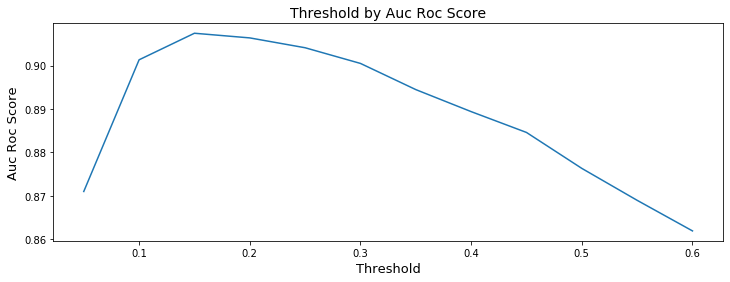

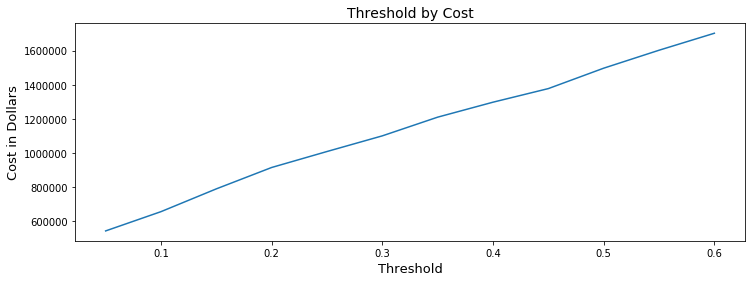

Best threshold by cost: 0.05
Best threshold by roc auc score: 0.15 

threshold results dataframe:
     threshold  roc_auc_score  total_cost   fn     fp
0        0.05       0.871006      542280  101  11964
1        0.10       0.901316      655280  175   6514
2        0.15       0.907426      788960  235   4198
3        0.20       0.906355      914400  285   2970
4        0.25       0.904089     1008120  321   2256
5        0.30       0.900480     1099980  355   1749
6        0.35       0.894456     1209640  394   1382
7        0.40       0.889390     1297440  425   1122
8        0.45       0.884595     1377240  453    912
9        0.50       0.876324     1496940  494    747
10       0.55       0.868974     1602240  530    612
11       0.60       0.861932     1701920  564    496

roc auc score: 0.9074262634609415 

              precision    recall  f1-score   support

           0       1.00      0.93      0.96     56945
           1       0.31      0.89      0.46      2109

    accurac

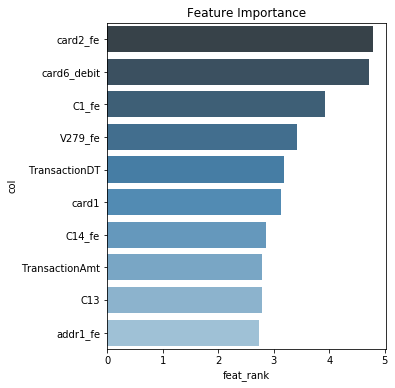

                 col  feat_rank
0           card2_fe   4.786506
1        card6_debit   4.717627
2              C1_fe   3.920392
3            V279_fe   3.423023
4      TransactionDT   3.188678
5              card1   3.133645
6             C14_fe   2.855401
7     TransactionAmt   2.794030
8                C13   2.786505
9           addr1_fe   2.726526
10              M6_T   2.579528
11                C2   2.551713
12  P_emaildomain_fe   2.351087
13  card4_mastercard   2.331706
14           V294_fe   2.114467
15               V97   1.860452
16               C11   1.734322
17           V306_fe   1.712662
18                C8   1.693151
19              V280   1.568541


In [414]:
# 0.9077
bool_predict_proba = True
model_current = CatBoostClassifier(
                                   max_depth=10,
                                   random_state=42, 
                                   verbose=0)
mod.create_df_score_model(model_current)

### Test Models

Fitting model:
 LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=-1, penalty='l2', random_state=42,
                   solver='warn', tol=0.0001, verbose=0, warm_start=False)
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=-1, penalty='l2', random_state=42,
                   solver='warn', tol=0.0001, verbose=0, warm_start=False)


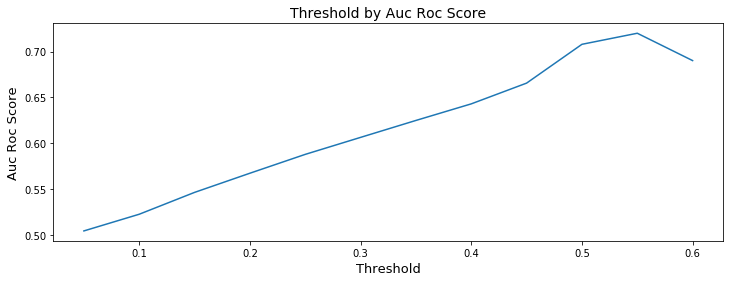

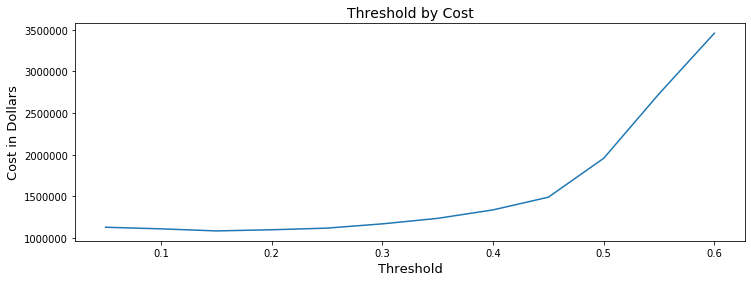

Best threshold by cost: 0.15
Best threshold by roc auc score: 0.55 

threshold results dataframe:
     threshold  roc_auc_score  total_cost    fn     fp
0        0.05       0.504276     1129160     0  56458
1        0.10       0.522478     1109840     9  54142
2        0.15       0.546325     1085040    21  51102
3        0.20       0.567240     1098900    46  48045
4        0.25       0.587812     1118460    73  44973
5        0.30       0.606356     1169700   111  41835
6        0.35       0.624838     1235840   155  38542
7        0.40       0.642934     1337300   213  34915
8        0.45       0.665578     1489900   296  30095
9        0.50       0.707924     1956780   525  19089
10       0.55       0.720003     2731220   851   8911
11       0.60       0.690157     3458480  1119   5074

roc auc score: 0.7200034505439998 

              precision    recall  f1-score   support

           0       0.98      0.84      0.91     56945
           1       0.12      0.60      0.20      2109

In [388]:
# BASE LogisticRegression
bool_predict_proba = True
model_current = LogisticRegression(random_state=42, n_jobs=-1)
mod.create_df_score_model(model_current)

Fitting model:
 LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=0.1, l1_ratio=0.01, max_iter=150,
                   multi_class='auto', n_jobs=-1, penalty='none',
                   random_state=42, solver='newton-cg', tol=1e-06, verbose=0,
                   warm_start=False)
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=0.1, l1_ratio=0.01, max_iter=150,
                   multi_class='auto', n_jobs=-1, penalty='none',
                   random_state=42, solver='newton-cg', tol=1e-06, verbose=0,
                   warm_start=False)


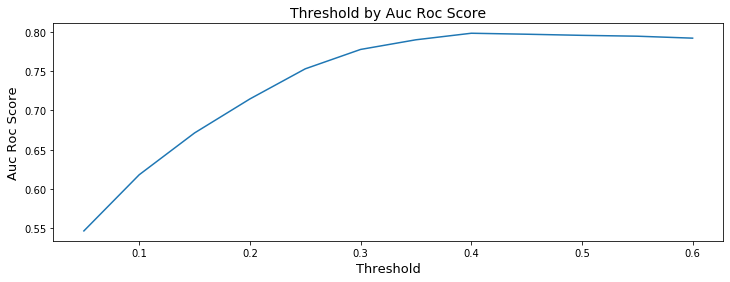

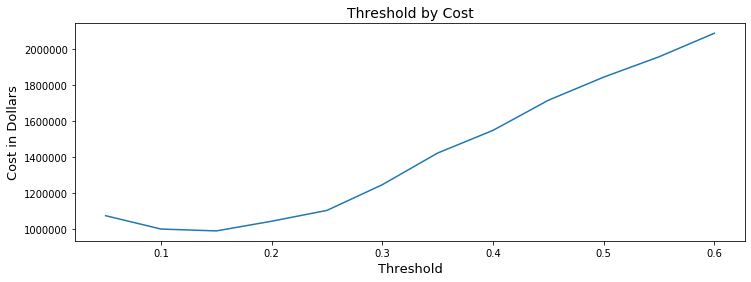

Best threshold by cost: 0.15
Best threshold by roc auc score: 0.4 

threshold results dataframe:
     threshold  roc_auc_score  total_cost   fn     fp
0        0.05       0.546712     1074320   17  51166
1        0.10       0.618193     1000060   53  42053
2        0.15       0.671384      989600   98  34780
3        0.20       0.714653     1043560  160  28178
4        0.25       0.752970     1103880  220  22194
5        0.30       0.777634     1246960  301  17198
6        0.35       0.789926     1423140  384  13557
7        0.40       0.798249     1549320  443  11016
8        0.45       0.797002     1716980  510   9349
9        0.50       0.795579     1845680  561   8134
10       0.55       0.794481     1958880  606   7044
11       0.60       0.791996     2090000  657   5950

roc auc score: 0.7982490112888327 

              precision    recall  f1-score   support

           0       0.99      0.81      0.89     56945
           1       0.13      0.79      0.23      2109

    accuracy

In [389]:
# TUNED LogisticRegression
bool_predict_proba = True
model_current =  LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                                    intercept_scaling=0.1, l1_ratio=0.01, max_iter=150,
                                    multi_class='auto', n_jobs=-1, penalty='none',
                                    random_state=42, solver='newton-cg', tol=1e-06, verbose=0,
                                    warm_start=False)

mod.create_df_score_model(model_current)


Fitting model:
 XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)


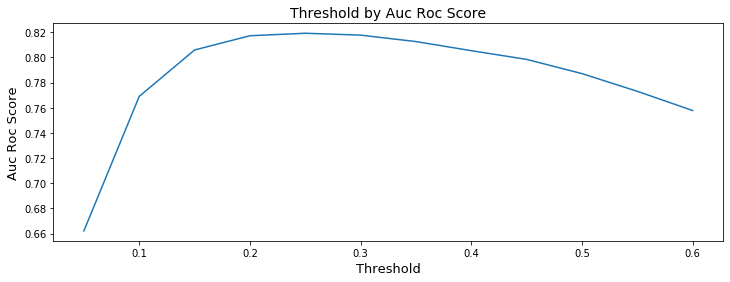

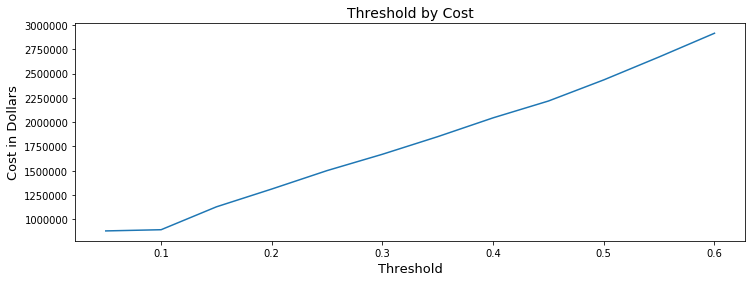

Best threshold by cost: 0.05
Best threshold by roc auc score: 0.25 

threshold results dataframe:
     threshold  roc_auc_score  total_cost   fn     fp
0        0.05       0.662130      880300   45  37265
1        0.10       0.769057      892580  149  22279
2        0.15       0.805916     1128420  279  14571
3        0.20       0.817242     1311720  364  10986
4        0.25       0.819234     1501520  443   8626
5        0.30       0.817741     1669740  510   6987
6        0.35       0.812621     1851140  579   5707
7        0.40       0.805386     2044740  651   4587
8        0.45       0.798457     2217960  715   3648
9        0.50       0.787174     2435540  793   2827
10       0.55       0.773090     2671800  876   2190
11       0.60       0.757829     2915660  961   1633

roc auc score: 0.819234172409212 

              precision    recall  f1-score   support

           0       0.99      0.85      0.91     56945
           1       0.16      0.79      0.27      2109

    accuracy

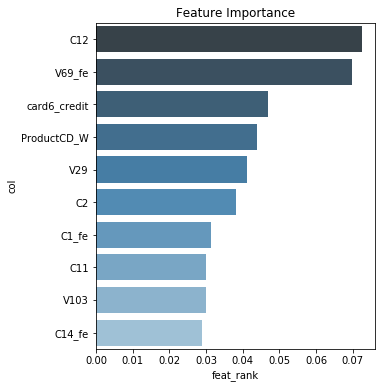

                 col  feat_rank
0                C12   0.072425
1             V69_fe   0.069921
2       card6_credit   0.047008
3        ProductCD_W   0.043823
4                V29   0.041301
5                 C2   0.038276
6              C1_fe   0.031356
7                C11   0.029979
8               V103   0.029896
9             C14_fe   0.028987
10           V317_fe   0.025630
11                C6   0.024823
12               V97   0.024282
13          card2_fe   0.022373
14              V102   0.022326
15               V90   0.021316
16               V34   0.020517
17        card4_visa   0.020478
18  card4_mastercard   0.019181
19           V294_fe   0.018210


In [390]:
# BASE XGBClassifier
bool_predict_proba = True
model_current = XGBClassifier(n_jobs=-1,random_state=42)
mod.create_df_score_model(model_current)

Fitting model:
 XGBClassifier(base_score=0.4, booster='gbtree', colsample_bylevel=0.3,
              colsample_bynode=0.5, colsample_bytree=0.7, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=13,
              min_child_weight=1, missing=None, n_estimators=150, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=3, reg_lambda=5, scale_pos_weight=5, seed=None,
              silent=None, subsample=0.5, verbosity=1)
XGBClassifier(base_score=0.4, booster='gbtree', colsample_bylevel=0.3,
              colsample_bynode=0.5, colsample_bytree=0.7, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=13,
              min_child_weight=1, missing=None, n_estimators=150, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=3, reg_lambda=5, scale_pos_weight=5, seed=None,
              silent=None, subsample=0.5, verbosity=1)


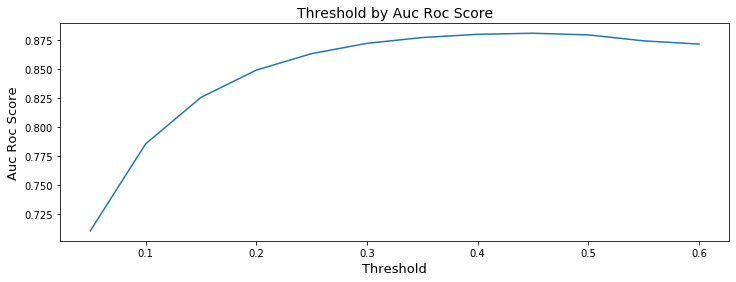

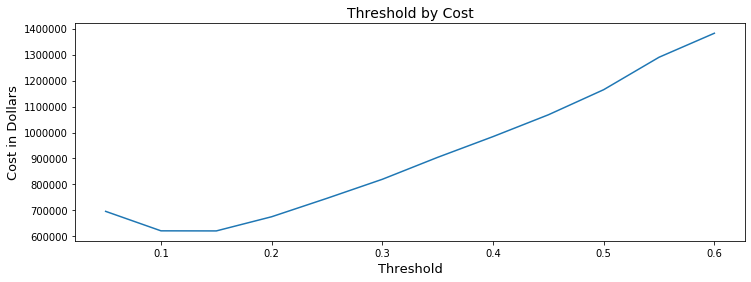

Best threshold by cost: 0.15
Best threshold by roc auc score: 0.45 

threshold results dataframe:
     threshold  roc_auc_score  total_cost   fn     fp
0        0.05       0.710466      696400   15  32570
1        0.10       0.785512      621400   54  22970
2        0.15       0.825612      621080   91  17404
3        0.20       0.849169      675660  135  13533
4        0.25       0.863375      746620  177  10781
5        0.30       0.872252      819880  215   8744
6        0.35       0.877257      904420  254   7121
7        0.40       0.880031      984200  289   5860
8        0.45       0.880961     1068180  324   4809
9        0.50       0.879539     1164900  362   3945
10       0.55       0.874393     1289780  408   3289
11       0.60       0.871609     1382220  443   2661

roc auc score: 0.880961390336087 

              precision    recall  f1-score   support

           0       0.99      0.92      0.95     56945
           1       0.27      0.85      0.41      2109

    accuracy

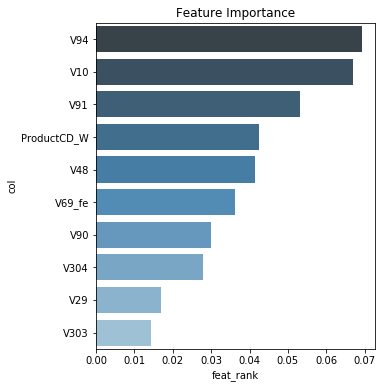

            col  feat_rank
0           V94   0.069213
1           V10   0.067085
2           V91   0.053089
3   ProductCD_W   0.042379
4           V48   0.041498
5        V69_fe   0.036152
6           V90   0.029944
7          V304   0.027807
8           V29   0.016858
9          V303   0.014452
10          V70   0.012842
11  card6_debit   0.012773
12          V34   0.011939
13         V302   0.011832
14          V69   0.011262
15     card6_fe   0.011004
16         V280   0.010375
17          C11   0.009594
18       C14_fe   0.009494
19      V317_fe   0.009240


In [391]:
# TUNED XGBClassifier n_estimators=150
bool_predict_proba = True
model_current = XGBClassifier(base_score=0.4, booster='gbtree', colsample_bylevel=0.3,
                              colsample_bynode=0.5, colsample_bytree=0.7, gamma=0,
                              learning_rate=0.1, max_delta_step=0, max_depth=13,
                              min_child_weight=1, missing=None, n_estimators=150, n_jobs=-1,
                              nthread=None, objective='binary:logistic', random_state=42,
                              reg_alpha=3, reg_lambda=5, scale_pos_weight=5, seed=None,
                              silent=None, subsample=0.5, verbosity=1)
mod.create_df_score_model(model_current)

Fitting model:
 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators='warn',
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                       oob_score=False, random_state=42, verbose=0,
                       warm_start=False)


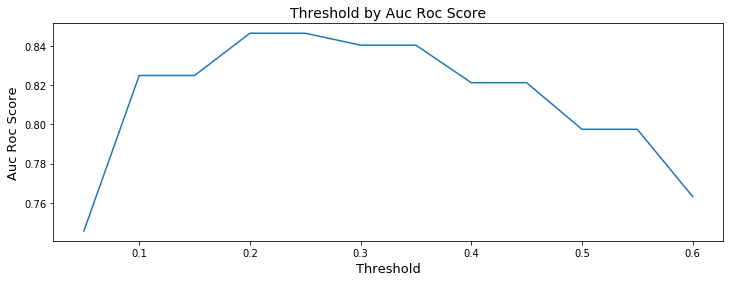

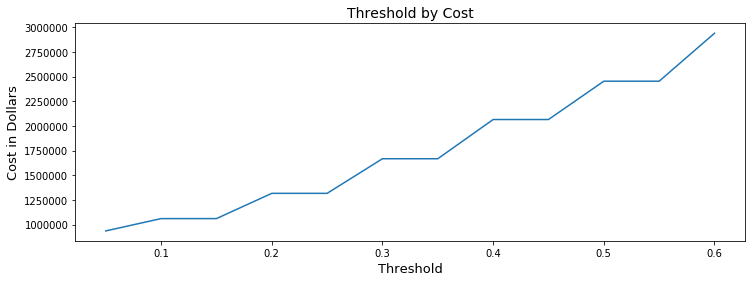

Best threshold by cost: 0.05
Best threshold by roc auc score: 0.2 

threshold results dataframe:
     threshold  roc_auc_score  total_cost   fn     fp
0        0.05       0.745753      935820  145  25041
1        0.10       0.824829     1060740  269  12687
2        0.15       0.824829     1060740  269  12687
3        0.20       0.846322     1316820  393   6891
4        0.25       0.846322     1316820  393   6891
5        0.30       0.840254     1667660  530   3883
6        0.35       0.840254     1667660  530   3883
7        0.40       0.821173     2065360  674   2168
8        0.45       0.821173     2065360  674   2168
9        0.50       0.797464     2453920  810   1196
10       0.55       0.797464     2453920  810   1196
11       0.60       0.763263     2940180  976    609

roc auc score: 0.8463221293486878 

              precision    recall  f1-score   support

           0       0.99      0.88      0.93     56945
           1       0.20      0.81      0.32      2109

    accuracy

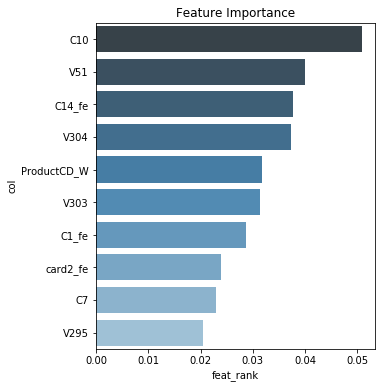

               col  feat_rank
0              C10   0.050809
1              V51   0.039913
2           C14_fe   0.037613
3             V304   0.037389
4      ProductCD_W   0.031814
5             V303   0.031363
6            C1_fe   0.028660
7         card2_fe   0.023932
8               C7   0.022953
9             V295   0.020425
10            V102   0.020370
11             V52   0.020290
12             V93   0.019743
13             C11   0.019412
14   TransactionDT   0.017736
15              C8   0.015150
16            V317   0.015145
17  TransactionAmt   0.015128
18             V30   0.012770
19           card1   0.011454


In [392]:
# BASE 0.8463 RandomForestClassifier
bool_predict_proba = True
model_current = RandomForestClassifier(n_jobs=-1, random_state=42)
mod.create_df_score_model(model_current)


Fitting model:
 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=150,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   28.6s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.7min finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=150,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    1.7s finished


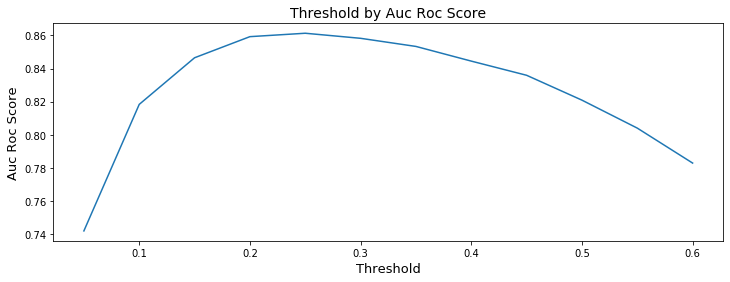

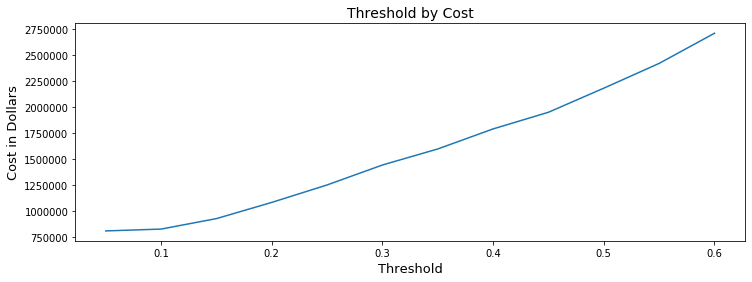

Best threshold by cost: 0.05
Best threshold by roc auc score: 0.25 

threshold results dataframe:
     threshold  roc_auc_score  total_cost   fn     fp
0        0.05       0.741785      809560   90  26978
1        0.10       0.818306      827140  168  16157
2        0.15       0.846508      927720  235  11136
3        0.20       0.859274     1083140  310   7657
4        0.25       0.861337     1250640  380   5532
5        0.30       0.858272     1442120  455   3856
6        0.35       0.853363     1595980  513   2849
7        0.40       0.844485     1788400  583   1970
8        0.45       0.835915     1948140  640   1407
9        0.50       0.820874     2179200  720    960
10       0.55       0.803962     2416980  801    699
11       0.60       0.782818     2706220  899    461

roc auc score: 0.8613367252580529 

              precision    recall  f1-score   support

           0       0.99      0.90      0.95     56945
           1       0.24      0.82      0.37      2109

    accurac

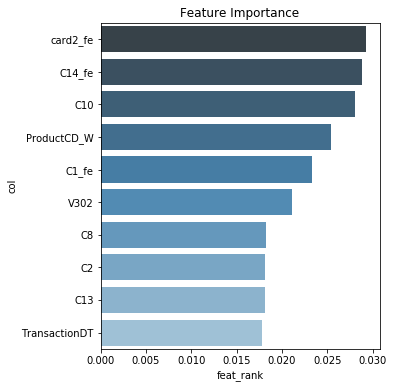

               col  feat_rank
0         card2_fe   0.029297
1           C14_fe   0.028800
2              C10   0.028065
3      ProductCD_W   0.025462
4            C1_fe   0.023350
5             V302   0.021057
6               C8   0.018192
7               C2   0.018104
8              C13   0.018084
9    TransactionDT   0.017772
10         V306_fe   0.016579
11         V317_fe   0.016435
12  TransactionAmt   0.015497
13            V317   0.014700
14     card6_debit   0.013854
15         V294_fe   0.013640
16        card3_fe   0.013152
17             C11   0.012999
18            V304   0.012127
19            V280   0.012111


In [393]:
# TUNED RandomForestClassifier
bool_predict_proba = True
model_current = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                                       min_impurity_decrease=0.0, min_impurity_split=None,
                                       min_samples_leaf=1, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0, n_estimators=150,
                                       n_jobs=-1, oob_score=False, random_state=42, verbose=1,
                                       warm_start=False)

mod.create_df_score_model(model_current)


Fitting model:


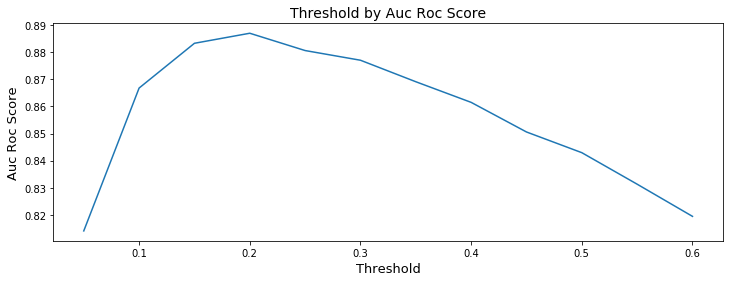

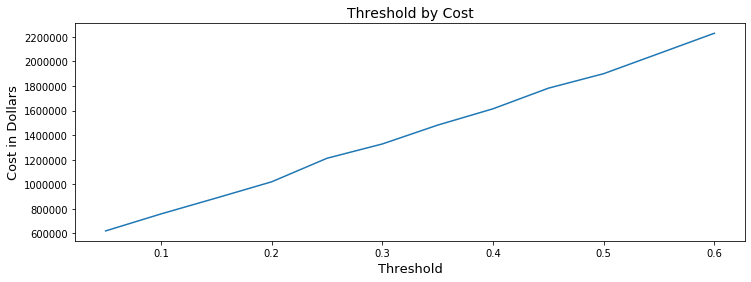

Best threshold by cost: 0.05
Best threshold by roc auc score: 0.2 

threshold results dataframe:
     threshold  roc_auc_score  total_cost   fn     fp
0        0.05       0.814074      620300   80  19015
1        0.10       0.866782      758540  185  10177
2        0.15       0.883298      888200  253   6460
3        0.20       0.887002     1019980  310   4499
4        0.25       0.880618     1211640  382   3282
5        0.30       0.877044     1328020  426   2501
6        0.35       0.869115     1481380  481   1919
7        0.40       0.861502     1614340  528   1517
8        0.45       0.850579     1781900  586   1195
9        0.50       0.842940     1900160  627    958
10       0.55       0.831314     2064400  683    770
11       0.60       0.819442     2229200  739    610

roc auc score: 0.8870024235825031 

              precision    recall  f1-score   support

           0       0.99      0.92      0.96     56945
           1       0.29      0.85      0.43      2109

    accuracy

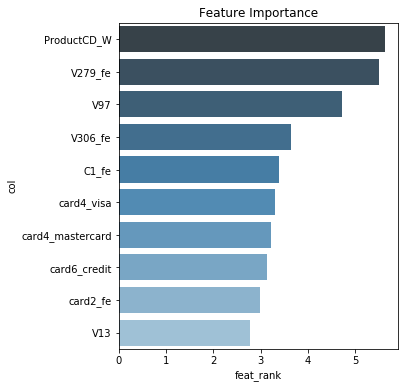

                 col  feat_rank
0        ProductCD_W   5.619865
1            V279_fe   5.510774
2                V97   4.722158
3            V306_fe   3.634200
4              C1_fe   3.392972
5         card4_visa   3.300172
6   card4_mastercard   3.227982
7       card6_credit   3.126668
8           card2_fe   2.982498
9                V13   2.776125
10               C13   2.683526
11                C2   2.571664
12              M6_T   2.550092
13            C14_fe   2.539744
14              V291   2.401199
15       card6_debit   1.968406
16          card6_fe   1.857563
17              V315   1.848805
18              M3_T   1.725574
19              V308   1.401024


In [394]:
# BASE CatBoostClassifier 
bool_predict_proba = True
model_current = CatBoostClassifier(random_state=42, verbose=0)
mod.create_df_score_model(model_current)

Fitting model:


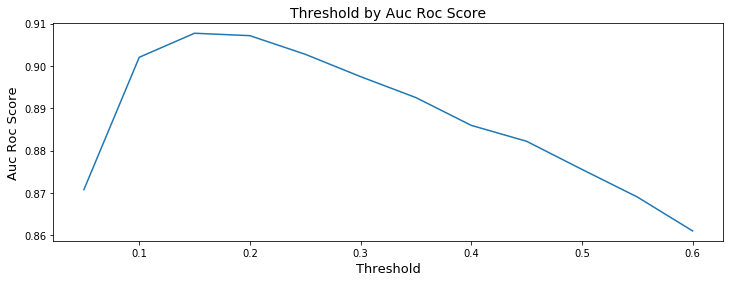

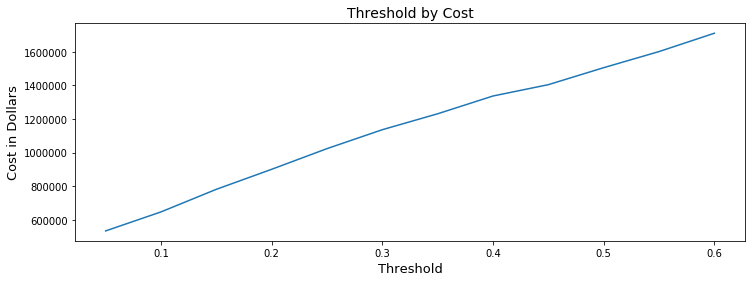

Best threshold by cost: 0.05
Best threshold by roc auc score: 0.15 

threshold results dataframe:
     threshold  roc_auc_score  total_cost   fn     fp
0        0.05       0.870778      532960   97  12098
1        0.10       0.902044      646240  172   6512
2        0.15       0.907725      780900  232   4245
3        0.20       0.907154      900280  280   3014
4        0.25       0.902754     1023460  326   2273
5        0.30       0.897477     1136340  367   1767
6        0.35       0.892525     1231260  401   1413
7        0.40       0.885965     1337220  438   1161
8        0.45       0.882207     1404820  462    941
9        0.50       0.875569     1506040  497    752
10       0.55       0.869053     1602060  530    603
11       0.60       0.861037     1711340  567    517

roc auc score: 0.9077248221135905 

              precision    recall  f1-score   support

           0       1.00      0.93      0.96     56945
           1       0.31      0.89      0.46      2109

    accurac

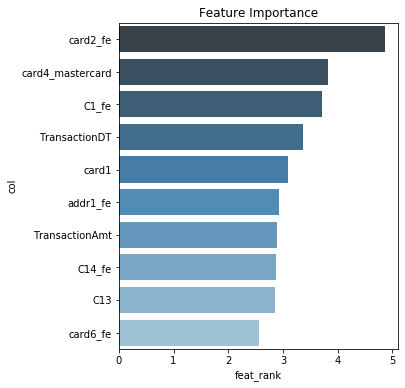

                 col  feat_rank
0           card2_fe   4.858432
1   card4_mastercard   3.816343
2              C1_fe   3.708417
3      TransactionDT   3.370225
4              card1   3.091591
5           addr1_fe   2.937765
6     TransactionAmt   2.888683
7             C14_fe   2.873176
8                C13   2.854464
9           card6_fe   2.556675
10              M6_T   2.493231
11  P_emaildomain_fe   2.465953
12                C2   2.421251
13               C11   2.208191
14           V294_fe   2.194179
15               V75   1.993872
16       card6_debit   1.823501
17           V306_fe   1.799582
18              V280   1.789759
19           V279_fe   1.428115


In [399]:
# TUNED CatboostClassifier
bool_predict_proba = True
model_current = CatBoostClassifier(
                                   max_depth=10,
                                   random_state=42, 
                                   verbose=0)
mod.create_df_score_model(model_current)
